In [1]:
import fabio
import os
from scipy.io import savemat
import matplotlib.pyplot as plt
import glob
import numpy as np
import pandas as pd
import numpy as np
import shutil


In [11]:
def nan_helper(y):
        """
        Helper to handle indices and logical indices of NaNs.

        Input:
            - y, 1d numpy array with possible NaNs

        Output:
            - nans, logical indices of NaNs
            - index, a function, with signature indices= index(logical_indices), to convert logical indices of NaNs to 'equivalent' indices
        """
        return np.isnan(y), lambda z: z.nonzero()
        

def azimuthal_integration(image, df, center = None, pixel_size=0.068, wavelength=0.15506, show = True):
    """Perform the radial integation of the converted image using fabio and calculate the q-values, intensities and standard deviation of the intensity.

    Args:
        image (_type_): _description_
        center (int, optional): beam center . Defaults to None.
        pixel_size (float, optional): Pixel size. Defaults to 0.068.
        wavelength (float, optional): wavelength in A. Defaults to 0.15506.

    Returns:
        DataFrame: q_values, Intensity, Std_intensity
    """
   #Calculate the distance in mm + hard coded value from Bruker
    distance = float(df['DISTANC'].item())*10+ 4.127

    if center is None:
        center = np.array([(x - 0.5) for x in image.shape])/2

    # Calculate the indices from the center
    y, x = np.indices((image.shape))
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2).astype(np.int64)
    max_radius = int(np.ceil(np.max(r)))

    # Calculate the azimuthal integration (radial profile)
    nans, _ = nan_helper(image.ravel())
    tbin = np.bincount(r.ravel(), np.nan_to_num(image).ravel())
    nr = np.bincount(r.ravel(), (~nans).ravel())
    radialprofile = np.divide(tbin, nr, out=np.zeros_like(tbin), where=nr!=0)
    radialprofile = radialprofile.astype(np.float64)

    # Calculate the standard deviation of the radial integrated intensity
    tbin_size = np.bincount(r.ravel())
    tbin_sum = np.bincount(r.ravel())
    tbin_mean = tbin_sum / tbin_size
    tbin_std = tbin_mean/np.sqrt(np.bincount(r.ravel()))

    # Convert radius to q-values
    r_values = np.arange(0, max_radius, 1)
    q_values = (4*np.pi/wavelength) * np.sin(np.arctan((r_values.astype(np.float64)*pixel_size)/distance))/2   
    q_values = q_values *10
    q_values = np.insert(q_values,0,q_values[0])
    
    if show == True:
        # Create a plot of radial integration vs q-values
        plt.figure()
        plt.loglog(q_values, radialprofile)
        plt.title(df['s_name'].item())
        plt.xlabel('Q-Values (1/nm)')
        plt.ylabel('Radial Integration')
        plt.show()
    elif show == False:
        pass
        
    return q_values, radialprofile,tbin_std

In [3]:
path = 'H:/test/images/'
extention = '*.gfrm'
files = glob.glob(os.path.join(path, extention))
print(files)

['H:/test/images\\00_emptybeam_7200s_unwarped.gfrm', 'H:/test/images\\00_empty_7200s_unwarped.gfrm', 'H:/test/images\\00_H2O_7200s_unwarped.gfrm', 'H:/test/images\\A1_P3_7200s_unwarped.gfrm', 'H:/test/images\\A3_P2_7200s_unwarped.gfrm', 'H:/test/images\\NG7338_600s_unwarped.gfrm']


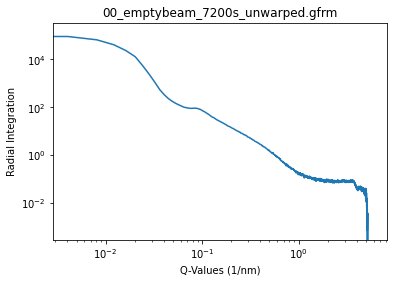

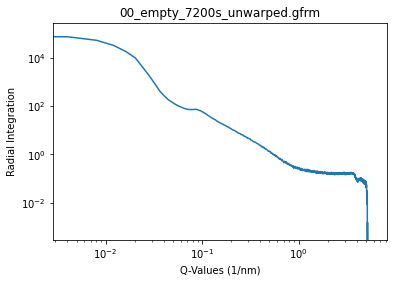

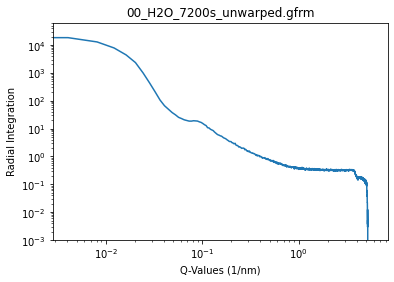

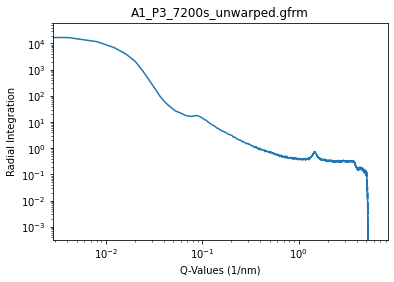

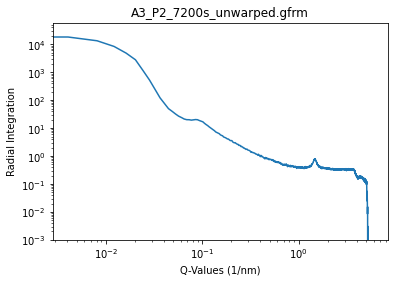

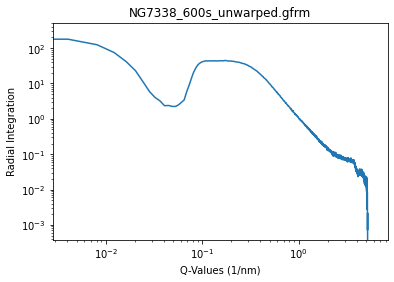

In [12]:
# Check if output folder already exist and if so, delete it. 
path_out_folder = (path + '1D/')
if os.path.exists(path_out_folder):
    shutil.rmtree(path_out_folder)
    
for filenames in os.listdir(path):
    filepath=os.path.join(path,filenames)
    
    # Run fabio and create the file
    image = fabio.open(path + filenames)
    Header_image= image.header
    df = pd.DataFrame.from_dict(dict(Header_image), orient='index', columns=['Value']).T
    
    # Define the name of the sample in the data frame 
    df['s_name'] = filenames
    
    # Define the image
    image = np.asarray(image.data)

    # Define the beam center based on the headers information
    center_image1 = [df['CENTER'].str.split(pat ='0 ').str[0],df['CENTER'].str.split(pat ='0 ').str[1]]
    center_image = [float(center_image1[0]),float(center_image1[1])]
    
    # Perform the radial integration of the data
    q_values, radialprofile,tbin_std = azimuthal_integration(image,df, center = None, pixel_size=0.068, wavelength=1.5506, show = True)
    
    # Create data frame to export
    data = {'qvalues':q_values,'Intensity':radialprofile,'std_intensity':tbin_std}
    data_to_save = pd.DataFrame(data = data)
 
    # Save the data
    path_out = (path + str.split(filenames,'.gfrm')[0] + '.dat_counts')
    np.savetxt(path_out , data_to_save.values)

# Create a folder in the parent path with radially integrated data

os.mkdir(path_out_folder)

# Move the files in the folder if they have the correct extension
extension = '.dat_counts'
for file_name in os.listdir(path):
    if file_name.endswith(extension):
        file_path = os.path.join(path, file_name)
        shutil.move(file_path, path_out_folder)